(Competencia de Kaggle)

In [2]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import pandas as pd
from pathlib import Path

In [4]:
path = fv.untar_data(fv.URLs.PLANET_SAMPLE)

Para descargar los datos

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/planet_sample/labels.csv'),Path('/root/.fastai/data/planet_sample/train')]

In [6]:
(path/'train').ls()

(#1000) [Path('/root/.fastai/data/planet_sample/train/train_24497.jpg'),Path('/root/.fastai/data/planet_sample/train/train_29464.jpg'),Path('/root/.fastai/data/planet_sample/train/train_16225.jpg'),Path('/root/.fastai/data/planet_sample/train/train_15617.jpg'),Path('/root/.fastai/data/planet_sample/train/train_34723.jpg'),Path('/root/.fastai/data/planet_sample/train/train_21148.jpg'),Path('/root/.fastai/data/planet_sample/train/train_28880.jpg'),Path('/root/.fastai/data/planet_sample/train/train_30502.jpg'),Path('/root/.fastai/data/planet_sample/train/train_20256.jpg'),Path('/root/.fastai/data/planet_sample/train/train_23253.jpg')...]

In [7]:
imgs = (path/'train').ls()

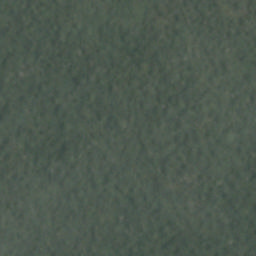

In [8]:
fv.PILImage.create(imgs[18])

Imagenes Satelitales del Amazonas

In [10]:
df = pd.read_csv(path/'labels.csv');df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [12]:
file2tags = dict(zip(df['image_name'],df['tags'])) #Pasar el csv a diccionario
{k: v for k, v in file2tags.items() if random.random()<0.01} #Dar una checada a unos cuantos valores

{'train_32374': 'partly_cloudy primary',
 'train_29518': 'partly_cloudy primary',
 'train_25128': 'agriculture clear primary road',
 'train_22217': 'partly_cloudy primary',
 'train_547': 'clear primary',
 'train_22708': 'clear primary water',
 'train_19162': 'agriculture partly_cloudy primary',
 'train_20768': 'cloudy',
 'train_26275': 'clear primary'}

In [15]:
def obtener_categorias(f):
    return file2tags[f.stem] #stem le quita la extension y el directorio padre

In [14]:
obtener_categorias(imgs[18])

'clear primary'

In [48]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True,
                            max_rotate=360, #permita todas las rotaciones
                            max_lighting=0.35, #Porque parece que algunas las tomaron a diferntes horas
                            max_zoom=1.1, #Porque parecen tomadas a la misma altura
                            max_warp=0.01) #No hay fotos tomadas en perspectiva
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.MultiCategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = obtener_categorias, #La funcion que creamos
                        splitter  = fv.RandomSplitter(1/10), #El 10 por ciento de las imagenes para validacion
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

In [19]:
data = load_data(path, img_size=224, batch_size=128)

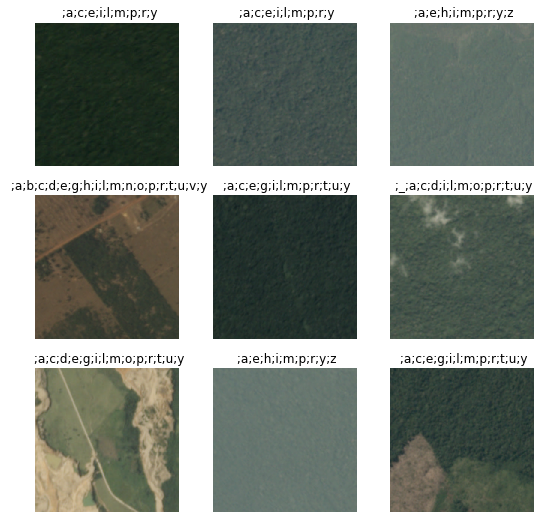

In [21]:
data.show_batch()

Fastai no require del string para las categorias. Necesitamos una lista. Modificaremos la función obtener_categorias

In [49]:
def obtener_categorias(f):
    return file2tags[f.stem].split(' ')

In [50]:
obtener_categorias(imgs[18])

['clear', 'primary']

Regresa una lista con las posibles categorías. Esto es lo que necesitamos

In [51]:
data = load_data(path,224, 128)

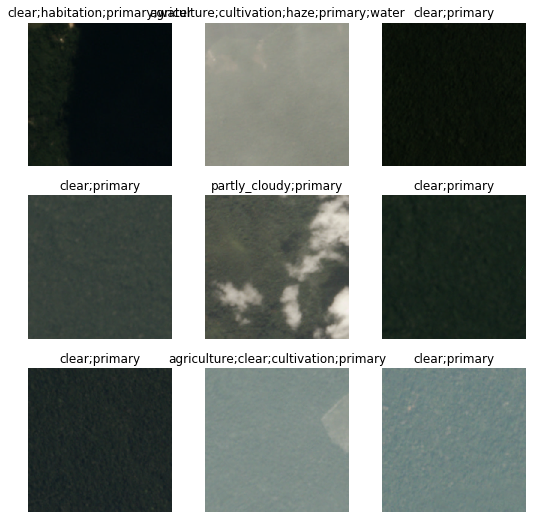

In [52]:
data.show_batch()

Ya tenemos cargados correctamente los datos

In [53]:
x,y = data.one_batch()

In [36]:
x.shape

torch.Size([128, 3, 336, 336])

batch de tamaño 128

In [54]:
y.shape

torch.Size([128, 17])

Hay 17 posibles categorias

In [39]:
y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')

Es como si estuviera one-hot-encodeado para las categorías

In [41]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std  = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [42]:
def create_learner(**kwards):
    learn = fv.cnn_learner(data, fv.resnet18, opt_func=fv.ranger, normalize=False, **kwards)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [56]:
learn = create_learner(metrics=fv.accuracy_multi) #accuracy para multiclasificacion

In [57]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

El modelo escupe 16 cosas que debo comparar con las categorias

Conceptualmente aplicamos sigmoide: cada categoría puede cumplirse o no, independientemente de as otras.

In [45]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

Hace cross entropy en cada categoría, sólo con tu predicción

Lo de with logics es que el modelo al final no le pone una capa sigmoide, y calcula la pérdida así

Siempre tratar de usar esa. Es más estable numéricamente

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.12022644281387329)

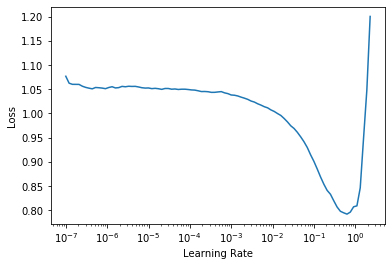

In [46]:
learn.lr_find()

In [58]:
learn.fit_one_cycle(1, 2e-2, div=0.9, pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.067631,0.902045,0.418235,00:12


## Score F2

In [59]:
fv.FBetaMulti(beta=2, average='samples')

In [60]:
learn = create_learner(metrics=[fv.accuracy_multi, fv.FBetaMulti(beta=2, average='samples')])

In [61]:
learn.fit_one_cycle(4, 2e-2, div=0.9, pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,1.053007,0.754886,0.541765,0.393870,00:10
1,1.013264,0.726889,0.610588,0.575260,00:10
2,0.942320,0.636639,0.653529,0.587532,00:10
3,0.879484,0.593157,0.698824,0.621517,00:10


In [64]:
thresholds = [0.1, 0.25, 0.5, 0.75] #Le decimosa partir de qué número se activa la clasificacion
metrics= [fv.FBetaMulti(beta=2, thresh=t) for t in thresholds]

metrics += [fv.accuracy_multi]
learn = create_learner(metrics=metrics)

In [65]:
learn.fit_one_cycle(1, 2e-2, div=0.9, pct_start=0.75)

epoch,train_loss,valid_loss,fbeta_score,fbeta_score,fbeta_score,fbeta_score,accuracy_multi,time
0,1.073599,0.874105,0.326666,0.265355,0.180839,0.084835,0.462941,00:10


#Todos se llaman igual. Para cambiarlo:

In [85]:
fv.AccumMetric.name=""
thresholds = [0.1, 0.25, 0.5, 0.75] #Le decimosa partir de qué número se activa la clasificacion
metrics= [fv.FBetaMulti(beta=2, thresh=t, average='samples') for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name = f"F2@{t}"
    
metrics += [fv.accuracy_multi]
learn = create_learner(metrics=metrics)

In [87]:
learn.fit_one_cycle(7, 2e-2, div=0.9, pct_start=0.75)

epoch,train_loss,valid_loss,F2@0.1,F2@0.25,F2@0.5,F2@0.75,accuracy_multi,time
0,0.999227,0.917576,0.514373,0.539603,0.593274,0.656269,0.595882,00:10
1,0.904203,0.693600,0.496472,0.534762,0.638349,0.615838,0.659412,00:10
2,0.823767,0.570356,0.493389,0.533027,0.652752,0.559317,0.744706,00:10
3,0.748195,0.428359,0.508845,0.596069,0.786229,0.612730,0.867059,00:10
4,0.663300,0.252988,0.586414,0.805592,0.868969,0.775237,0.941765,00:10
5,0.576560,0.166540,0.785045,0.887421,0.860269,0.824006,0.949412,00:10
6,0.502801,0.162062,0.784529,0.892244,0.884571,0.794433,0.957059,00:10


Aquí nos damos la idea de qué threshold debemos elegir

In [88]:
learn.unfreeze()

In [89]:
learn.fit_one_cycle(7, slice(3e-5, 1e-3), div=0.9, pct_start=0.75)

epoch,train_loss,valid_loss,F2@0.1,F2@0.25,F2@0.5,F2@0.75,accuracy_multi,time
0,0.226746,0.162839,0.780773,0.892925,0.854132,0.794433,0.952941,00:15
1,0.222627,0.161353,0.788203,0.892149,0.869631,0.796588,0.954706,00:13
2,0.221602,0.159954,0.796032,0.894635,0.867797,0.797883,0.954118,00:14
3,0.219173,0.156274,0.804756,0.891847,0.872631,0.795614,0.956471,00:13
4,0.217431,0.154328,0.815045,0.893744,0.864655,0.800280,0.955294,00:13
5,0.213863,0.151241,0.830888,0.887229,0.873869,0.798096,0.956471,00:13
6,0.211890,0.151753,0.824934,0.888986,0.869027,0.795473,0.955294,00:13


In [ ]:
thresholds = [0.15 + i*0.01 for i in range (20)]
metrics= [fv.FBetaMulti(beta=2, thresh=t, average='samples') for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name = f"F2@{t}"
    
metrics += [fv.accuracy_multi]

In [91]:
learn.metrics=metrics

Si el modelo ya está entrenado podemos usar lo siguiente:

In [92]:
learn.validate()

(#6) [0.15175271034240723,0.8249339211096495,0.8889856231805937,0.8690273742016487,0.7954728761689722,0.9552940130233765]